In [5]:
from __future__ import annotations

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import cv2

from polar_mnist.io import load_mnist
from polar_mnist.transforms import PolarAggregation

In [2]:
X_img, y_train, _, _ = load_mnist()

## Polar Projection Figure

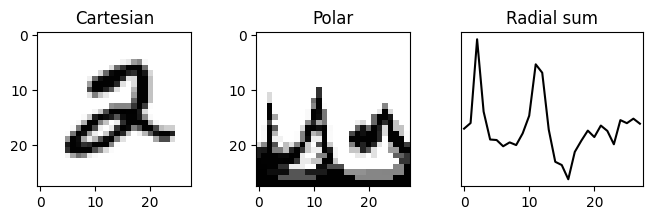

In [3]:
digit = X_img[5].astype(np.float32)
# digit = cv2.resize(digit, (128, 128))

value = np.sqrt(((digit.shape[0] / 2.0) ** 2.0) + ((digit.shape[1] / 2.0) ** 2.0))
polar_image = cv2.linearPolar(
    digit, (digit.shape[0] / 2, digit.shape[1] / 2), value, cv2.WARP_FILL_OUTLIERS
)
polar_image = polar_image.astype(np.uint8)
radial_sum = polar_image.sum(axis=1)

fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].imshow(digit, cmap="gray_r")
ax[0].set_title("Cartesian")
ax[0].set_xticks(np.arange(0, digit.shape[1], 10))
ax[0].set_yticks(np.arange(0, digit.shape[0], 10))

ax[1].imshow(cv2.rotate(polar_image, cv2.ROTATE_90_COUNTERCLOCKWISE), cmap="gray_r")
ax[1].set_title("Polar")
ax[1].set_xticks(np.arange(0, digit.shape[1], 10))
ax[1].set_yticks(np.arange(0, digit.shape[0], 10))


ax[2].plot(radial_sum, color="black")
ax[2].set_title("Radial sum")
ax[2].set_xticks(np.arange(0, digit.shape[1], 10))
ax[2].set_yticks([])
ax[2].set_xlim([-0.5, len(radial_sum) - 0.5])

fig.savefig("../figures/polar_transform.png", dpi=300)

## Radial Sum Animation

In [4]:
digit_original = X_img[5].astype(np.float32)
digit = cv2.resize(digit_original, (360, 360))

value = np.sqrt(((digit.shape[0] / 2.0) ** 2.0) + ((digit.shape[1] / 2.0) ** 2.0))
polar_image = cv2.linearPolar(
    digit, (digit.shape[0] / 2, digit.shape[1] / 2), value, cv2.WARP_FILL_OUTLIERS
)
polar_image = polar_image.astype(np.uint8)
radial_sum = polar_image.sum(axis=1)

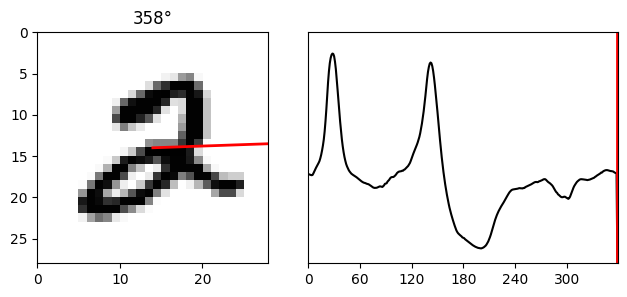

In [6]:
img = digit_original
height, width = img.shape
center = (width // 2, height // 2)
radius = min(center) * 1.414  # Maximum possible radius

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Make the subplot widths the same
fig.subplots_adjust(wspace=0.0)

ax[0].imshow(img, cmap="gray_r", extent=[0, width, height, 0])
(left_line,) = ax[0].plot([], [], "r-", lw=2)

radial_sum_line = ax[1].plot(np.zeros_like(radial_sum), color="black")
ax[1].set_xticks(np.arange(0, digit.shape[1], 60))
ax[1].set_yticks([])
ax[1].set_xlim([-0.5, len(radial_sum) - 0.5])
ax[1].set_ylim([0, radial_sum.max() + 5000])
right_line = ax[1].axvline(x=0, color="r", lw=2)


def init():
    left_line.set_data([], [])
    right_line.set_xdata([0])

    return left_line, right_line


def update(frame):
    deg = frame * 2
    angle = -np.radians(deg)  # Convert degrees to radians
    x_end = center[0] + radius * np.cos(angle)
    y_end = center[1] - radius * np.sin(angle)  # Invert Y because of image coordinates
    left_line.set_data([center[0], x_end], [center[1], y_end])

    # Reveal the radial sum values from the left, padding with zeros
    revealed_radial_sum = np.concatenate(
        [radial_sum[: deg + 1], np.full(len(radial_sum) - deg - 1, -1000)]
    )
    radial_sum_line[0].set_ydata(revealed_radial_sum)
    right_line.set_xdata([deg])
    ax[0].set_title(f"{deg}°")

    return left_line, right_line


ani = animation.FuncAnimation(
    fig, update, frames=range(180), init_func=init, blit=True, interval=20
)
ani.save("../figures/radial_sum.mp4", writer="ffmpeg", fps=30, dpi=100)

## Digit Signals

In [ ]:
def collect_digits(n: int) -> dict[int, np.ndarray]:
    X_img, y_train, _, _ = load_mnist()
    digits = {}
    for i in range(10):
        digits[i] = X_img[y_train == i][:n]

    return digits

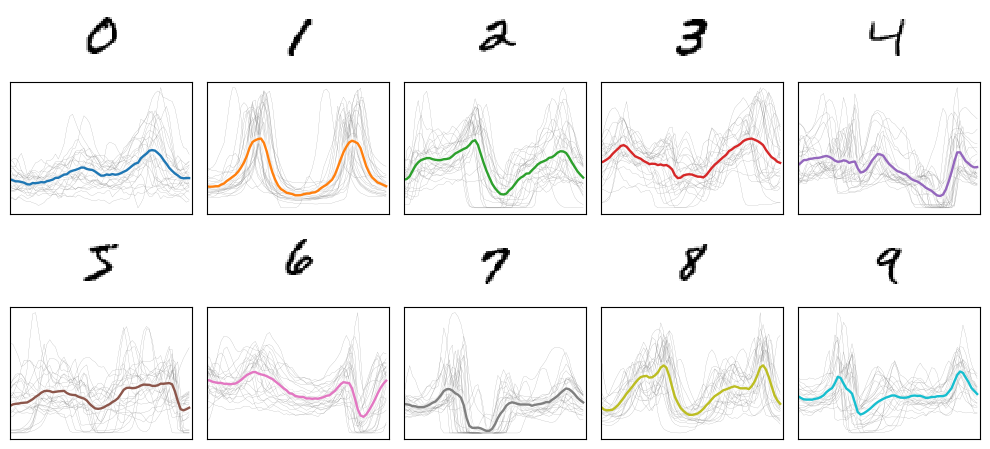

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(10, 5))

digits = collect_digits(25)
resolution = 64

palette = plt.get_cmap("tab10")
transformer = PolarAggregation(resolution)

for col in range(2):
    for row in range(5):
        i = row + col * 5
        img_col = col * 2
        line_col = col * 2 + 1

        signals = np.array([transformer(x) for x in digits[i]])
        color = palette.colors[i]
        digit = digits[i][0]

        # Pad the top of the digit with zeros to make it smaller
        digit = np.pad(digit, ((0, 0), (36, 36)), mode="constant", constant_values=0)

        # Plot the first digit image
        ax[img_col, row].imshow(digit, cmap="gray_r", interpolation="nearest")
        ax[img_col, row].set_xticks([])
        ax[img_col, row].set_yticks([])
        # Turn off image border
        for spine in ax[img_col, row].spines.values():
            spine.set_visible(False)

        # Plot each signal lightly
        for signal in signals:
            ax[line_col, row].plot(signal, color="gray", alpha=0.8, linewidth=0.15)

        # Plot the main signal in a dark color
        ax[line_col, row].plot(
            np.mean(signals, axis=0), color="white", alpha=0.5, linewidth=6
        )
        ax[line_col, row].plot(np.mean(signals, axis=0), color=color, linewidth=1.7)

        # Turn off axes
        ax[line_col, row].set_xticks([])
        ax[line_col, row].set_yticks([])
        ax[line_col, row].set_xlim([0, resolution])


plt.tight_layout()
# Reduce vertical space between rows
plt.subplots_adjust(hspace=-0.15)

plt.savefig("../figures/digit_signals.png", dpi=300)